### Markowitz Portfolio Optimization
#### Monte-Carlo Approach

In [16]:
# calculations
import pandas as pd
import numpy as np

# plotting 
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# data
import yfinance as yf

from tqdm import tqdm

# Portfolio Solver
import cvxpy as cp

#  import cvxopt as cp
from cvxopt import matrix, solvers

In [2]:
# import data
daily_returns = yf.download(["AAPL","JPM","WMT","TGT","MSFT","AMGN"], period= "5y", interval="1d")
dr = daily_returns["Adj Close"].pct_change()

[*********************100%***********************]  6 of 6 completed


In [3]:
# annulized retruns
mus = (1+dr.mean())**252 - 1 

# convariance
covar = dr.cov()*252
covar


,AAPL,AMGN,JPM,MSFT,TGT,WMT
AAPL,0.095976,0.036509,0.042171,0.065478,0.032296,0.024372
AMGN,0.036509,0.063669,0.031187,0.037392,0.025781,0.022266
JPM,0.042171,0.031187,0.094129,0.041587,0.030712,0.018234
MSFT,0.065478,0.037392,0.041587,0.080260,0.032389,0.024945
TGT,0.032296,0.025781,0.030712,0.032389,0.096473,0.030137
WMT,0.024372,0.022266,0.018234,0.024945,0.030137,0.048517


In [4]:
n_assets = 5
n_portfolios = 1000

mean_variance_pairs = []

np.random.seed(1993)

for i in range(n_portfolios):
    assets = np.random.choice(list(dr.columns), n_assets, replace = False)
    weights = np.random.rand(n_assets)
    weights = weights/sum(weights)

    portfolio_E_retruns = 0
    portfolio_E_variance = 0

    for i in range(len(assets)):
        portfolio_E_retruns += weights[i] * mus.loc[assets[i]]

        for j in range(len(assets)):
            portfolio_E_variance += weights[i] * weights[j] * covar.loc[assets[i],assets[j]]

    mean_variance_pairs.append([portfolio_E_retruns,portfolio_E_variance])

In [5]:
# mean_variance_pairs

In [6]:
# Plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.32])
fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [7]:
n_assets = 5

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(dr.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * covar.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████| 10000/10000 [00:02<00:00, 3561.80it/s]


In [8]:
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.35])
fig.update_yaxes(range=[0.05,0.29])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

#### Temperature Targeting Program
$$ 
max \left( x' \mu - \frac{RA}{2} x' \sum x \right)  \\
s.t. \; x'T \leq \bar{T} \\
\; \; x \geq 0 \\
\\
x' \mu \;: \; \text{Expected Return} \\
\frac{RA}{2} x' \sum x \; : \; \text{Risk aversion} \\
\bar{T} \; : \; 

$$

#### TA Utility 
$$
max \left( x' \mu - \frac{RA}{2} x' \sum x - \; TA \; x'T \right)  \\
s.t. \; x \geq 0
$$

In [5]:
Sigma = covar.to_numpy()
Sigma

array([[0.09597616, 0.03650915, 0.04217098, 0.06547829, 0.03229649,
        0.02437234],
       [0.03650915, 0.06366854, 0.03118738, 0.03739162, 0.02578054,
        0.02226571],
       [0.04217098, 0.03118738, 0.09412855, 0.04158739, 0.03071208,
        0.01823384],
       [0.06547829, 0.03739162, 0.04158739, 0.08026002, 0.03238896,
        0.02494535],
       [0.03229649, 0.02578054, 0.03071208, 0.03238896, 0.09647317,
        0.03013736],
       [0.02437234, 0.02226571, 0.01823384, 0.02494535, 0.03013736,
        0.04851693]])

In [6]:
n = Sigma.shape[0]

In [7]:
# mu = dr.mean().values
# mu

In [9]:
mu =  np.array(mus)
mu


array([0.45581202, 0.15004441, 0.1752868 , 0.43975576, 0.41435728,
       0.21337486])

In [10]:
asset_vols = np.sqrt(Sigma.diagonal())
asset_vols

array([0.30980019, 0.25232626, 0.30680376, 0.28330199, 0.31060131,
       0.22026558])

In [12]:
w = cp.Variable(n)
w

Variable((6,))

In [13]:
ret = mu.T @ w
ret

Expression(AFFINE, UNKNOWN, ())

In [14]:
vol = cp.quad_form(w, Sigma)

In [15]:
vol

Expression(CONVEX, NONNEGATIVE, (1, 1))

In [16]:
prob = cp.Problem(cp.Minimize(vol),  
                  [cp.sum(w) == 1,   
                   w >= 0]           
                 )

In [17]:
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value
minvol

0.0347271140723035

In [18]:
prob = cp.Problem(cp.Maximize(ret),  
                  [cp.sum(w) == 1, 
                   w >= 0]
                )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxretvol

0.09597613744547383

In [21]:
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit  
                  ]
                 )

# define helper function 
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate over vl_vals
results_dict = {}
for vl_val in vl_vals:
    results_dict[vl_val] = solve_vl(vl_val)

minvol, maxretvol


NameError: name 'ret' is not defined

In [105]:
list(results_dict)

[0.034727151222293,
 0.035034934924778854,
 0.035342718627264715,
 0.03565050232975057,
 0.03595828603223643,
 0.03626606973472228,
 0.03657385343720814,
 0.036881637139693994,
 0.037189420842179854,
 0.03749720454466571,
 0.03780498824715157,
 0.03811277194963742,
 0.03842055565212328,
 0.038728339354609134,
 0.03903612305709499,
 0.03934390675958085,
 0.03965169046206671,
 0.03995947416455256,
 0.040267257867038414,
 0.040575041569524274,
 0.04088282527201013,
 0.04119060897449599,
 0.04149839267698184,
 0.0418061763794677,
 0.042113960081953554,
 0.042421743784439414,
 0.04272952748692527,
 0.04303731118941113,
 0.04334509489189698,
 0.04365287859438284,
 0.043960662296868694,
 0.04426844599935455,
 0.04457622970184041,
 0.04488401340432627,
 0.04519179710681212,
 0.045499580809297974,
 0.045807364511783834,
 0.04611514821426969,
 0.04642293191675555,
 0.0467307156192414,
 0.04703849932172726,
 0.047346283024213114,
 0.047654066726698974,
 0.04796185042918483,
 0.04826963413167068,


In [106]:
vola = []
returns = []
for i in list(results_dict):
    vola.append(results_dict[i][1])
    returns.append(results_dict[i][0])

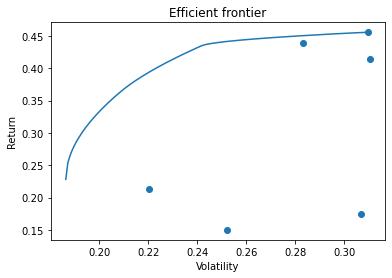

In [111]:
plt.plot(vola,returns)    
plt.scatter(asset_vols,mu)
plt.title("Efficient frontier")
plt.xlabel("Volatility")
plt.ylabel("Return");

In [108]:
mus

AAPL    0.455812
AMGN    0.150044
JPM     0.175287
MSFT    0.439756
TGT     0.414357
WMT     0.213375
dtype: float64

In [110]:
asset_vols

array([0.30980011, 0.25232638, 0.30680387, 0.28330194, 0.31060138,
       0.22026562])

In [27]:
correl = np.array([[1,0,0.75,0.48,0.75,0.48],[0,1,0.06,0.06,0.06,0.06],
        [0.75,0.06,1,0.36,0.63,0.36],[0.48,0.06,0.36,1,0.36,0.6],
        [0.75,0.06,0.63,0.36,1,0.36],[0.48,0.06,0.36,0.6,0.36,1]])

In [28]:
correl

array([[1.  , 0.  , 0.75, 0.48, 0.75, 0.48],
       [0.  , 1.  , 0.06, 0.06, 0.06, 0.06],
       [0.75, 0.06, 1.  , 0.36, 0.63, 0.36],
       [0.48, 0.06, 0.36, 1.  , 0.36, 0.6 ],
       [0.75, 0.06, 0.63, 0.36, 1.  , 0.36],
       [0.48, 0.06, 0.36, 0.6 , 0.36, 1.  ]])

In [ ]:
np.cov(correl,rowvar=)

#### First-Stage Markowitz Mean Variance Portfolio Optimization
$$ 
max \left( x' \mu - \frac{RA}{2} x' \sum x \right)  \\
\;s.t. \; x \geq 0 \\

$$

##### Revealed Preferences
$$
\bar{R}_{RA} = \bar{x}_{RA}' \mu \\
\bar{V}_{RA} = \sqrt{\bar{x}_{RA} ' \sum \bar{x}_{RA}} \\ 
\bar{U}_{RA} = \bar{R}_{RA} - \frac{RA}{2}\bar{V}_{RA}

$$

#### Second-Stage Maximum Impact Optimization
##### Risk and retrun preservation
$$
max (x'I_{Impact}) \\
s.t. \; \; x'\mu = \bar{R}_{RA} \\
\sqrt{\bar{x} ' \sum \bar{x}} = \bar{V}_{RA}  \\ 
$$
##### Utility preservation
$$
max (x'I_{Impact}) \\
s.t. \; \; x'\mu - \frac{RA}{2} x' \sum x = \bar{U}_{RA} \\


$$

In [43]:
correl_Imp = np.array([[1,0,0.75,0.48,0.75,0.48],[0,1,0.06,0.06,0.06,0.06],
        [0.75,0.06,1,0.36,0.63,0.36],[0.48,0.06,0.36,1,0.36,0.6],
        [0.75,0.06,0.63,0.36,1,0.36],[0.48,0.06,0.36,0.6,0.36,1]])
vol_lst_Imp = [15,4,20,12.5,20.5,13.5]
correl_Imp, vol_lst_Imp

(array([[1.  , 0.  , 0.75, 0.48, 0.75, 0.48],
        [0.  , 1.  , 0.06, 0.06, 0.06, 0.06],
        [0.75, 0.06, 1.  , 0.36, 0.63, 0.36],
        [0.48, 0.06, 0.36, 1.  , 0.36, 0.6 ],
        [0.75, 0.06, 0.63, 0.36, 1.  , 0.36],
        [0.48, 0.06, 0.36, 0.6 , 0.36, 1.  ]]),
 [15, 4, 20, 12.5, 20.5, 13.5])

Correlation to covariance matrix
$$
cov_{x,y} = r_{x,y} * \sigma_{x} * \sigma{y}
$$

In [50]:
correl = correl_Imp[:4,:4] 
vol_lst = vol_lst_Imp[:4]
correl,vol_lst


(array([[1.  , 0.  , 0.75, 0.48],
        [0.  , 1.  , 0.06, 0.06],
        [0.75, 0.06, 1.  , 0.36],
        [0.48, 0.06, 0.36, 1.  ]]),
 [15, 4, 20, 12.5])

In [44]:
from Functions.Statistics import *

In [52]:
def corr_to_cov(corr, st):
    if len(corr) != len(st):
        print("The dimensions don't match")
    variance = np.power(st,2)
    dimension = len(corr)
    covari = np.zeros((dimension,dimension))
    for i in range(dimension):
        covari[i][i] = variance[i]
    for j in range(len(st)):
        for i in range(0,len(st)):
            covari[j][i] = st[j] * st[i] * corr[j][i]
    return np.around(covari, decimals= 4) 

In [53]:
covar = corr_to_cov(correl, vol_lst)
covar

array([[225.  ,   0.  , 225.  ,  90.  ],
       [  0.  ,  16.  ,   4.8 ,   3.  ],
       [225.  ,   4.8 , 400.  ,  90.  ],
       [ 90.  ,   3.  ,  90.  , 156.25]])

In [54]:
n = len(vol_lst)
n

4

In [55]:
mu_Imp = np.array([5.5,2,6,2.5,5.2,3])
mu = mu_Imp[:4]

In [56]:
w = cp.Variable(n)
w

Variable((4,))

In [57]:
ret = mu.T @ w
ret

Expression(AFFINE, UNKNOWN, ())

In [58]:
vol = cp.quad_form(w, covar)
vol

Expression(CONVEX, NONNEGATIVE, (1, 1))

In [59]:
covar = corr_to_cov(correl, vol_lst)
covar

array([[225.  ,   0.  , 225.  ,  90.  ],
       [  0.  ,  16.  ,   4.8 ,   3.  ],
       [225.  ,   4.8 , 400.  ,  90.  ],
       [ 90.  ,   3.  ,  90.  , 156.25]])

In [60]:
prob = cp.Problem(cp.Minimize(vol),  
                  [cp.sum(w) == 1,   
                   w >= 0]           
                 )

In [61]:
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value
minvol

14.627129144777589

In [62]:
prob = cp.Problem(cp.Maximize(ret),  
                  [cp.sum(w) == 1, 
                   w >= 0]
                )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxretvol

399.99998308940627

In [63]:
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit  
                  ]
                 )

# define helper function 
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate over vl_vals
results_dict = {}
for vl_val in vl_vals:
    results_dict[vl_val] = solve_vl(vl_val)

minvol, maxretvol


C:\Users\benja\.conda\envs\mlcourse\lib\site-packages\cvxpy\problems\problem.py:1333: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(14.627129144777589, 399.99998308940627)

In [65]:
vola = []
returns = []
for i in list(results_dict):
    vola.append(results_dict[i][1])
    returns.append(results_dict[i][0])

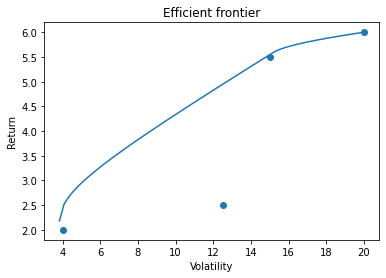

In [66]:
plt.plot(vola,returns)    
plt.scatter(vol_lst,mu)
plt.title("Efficient frontier")
plt.xlabel("Volatility")
plt.ylabel("Return");

In [122]:
volat = list(results_dict)

In [69]:
results_dict[list(results_dict)[0]]

(2.182449521160615,
 3.82454305524845,
 array([4.49323702e-02, 9.04695150e-01, 2.46860332e-08, 5.03724147e-02]))

In [135]:
weights = pd.DataFrame()
for i in list(results_dict):
    # print(pd.DataFrame([results_dict[i][2]]))
    weights = weights.append(pd.DataFrame([results_dict[i][2]]), ignore_index=True)
weights.index = np.sqrt(volat)

In [136]:
weights

,0,1,2,3
3.824543,4.493237e-02,9.046952e-01,2.468603e-08,5.037241e-02
4.069850,1.480484e-01,8.482546e-01,2.520775e-07,3.696822e-03
4.301189,1.861663e-01,8.122474e-01,1.586205e-03,4.443488e-09
4.520705,2.084441e-01,7.835411e-01,8.014872e-03,3.650291e-09
4.730044,2.271563e-01,7.594857e-01,1.335794e-02,1.751946e-09
...,...,...,...,...
19.805398,2.238250e-02,2.400175e-10,9.776175e-01,2.720073e-10
19.854227,1.673912e-02,1.922747e-10,9.832609e-01,2.220168e-10
19.902937,1.112795e-02,1.827580e-10,9.888721e-01,2.071080e-10
19.951527,5.548433e-03,8.299601e-10,9.944516e-01,9.240231e-10


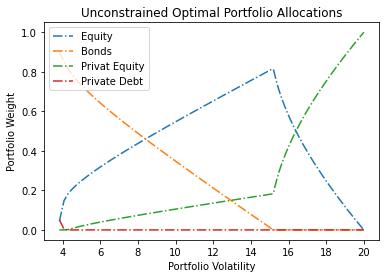

In [161]:
plt.plot(weights, linestyle = "-.")
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Weight")
plt.legend(["Equity","Bonds","Privat Equity","Private Debt"])
plt.title("Unconstrained Optimal Portfolio Allocations");
# plt.xticks(volat)